# Deep Dive: Boundary Conditions and Masking in Walrus

This notebook provides a detailed explanation of two critical concepts in Walrus:
1. **Boundary Conditions (BCs)** - How physics boundaries are handled
2. **Masking** - Two different types of masking and why each is needed

These concepts can be confusing because "padding" and "masking" appear in multiple contexts. Let's break them down with concrete examples and visualizations.

## Part 1: Boundary Conditions

### What are boundary conditions?

When solving PDEs on a finite domain, we need to specify what happens at the edges. Walrus supports three types:

| Type | Code | Physics Meaning | Example |
|------|------|-----------------|----------|
| **WALL/CLOSED** | 0 | Solid boundary, no-slip | Tank wall, obstacle |
| **OPEN** | 1 | Outflow/inflow | Domain inlet/outlet |
| **PERIODIC** | 2 | Wrapping (toroidal) | Repeating pattern |

### How are they encoded?

Shape: `[Batch, 3 dimensions, 2 sides]` = `[B, 3, 2]`

For each spatial dimension (x, y, z), we specify BC for lower bound (index 0) and upper bound (index 1).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch, FancyArrowPatch

# Example 1: All periodic (like a torus)
bc_periodic = torch.tensor([[[2, 2],  # x: periodic
                             [2, 2],  # y: periodic  
                             [2, 2]]])  # z: periodic

# Example 2: Channel flow (open on x, periodic on y, z)
bc_channel = torch.tensor([[[1, 1],  # x: open (inlet/outlet)
                            [2, 2],  # y: periodic
                            [2, 2]]])  # z: periodic

# Example 3: Box with walls (all closed)
bc_box = torch.tensor([[[0, 0],  # x: closed
                        [0, 0],  # y: closed
                        [0, 0]]])  # z: closed

# Example 4: Mixed boundaries
bc_mixed = torch.tensor([[[1, 1],  # x: open
                          [0, 0],  # y: closed (walls)
                          [2, 2]]])  # z: periodic

print("Example Boundary Conditions:\n")
print(f"1. Periodic (torus):     {bc_periodic[0].tolist()}")
print(f"2. Channel flow:         {bc_channel[0].tolist()}")
print(f"3. Closed box:           {bc_box[0].tolist()}")
print(f"4. Mixed (open/wall):    {bc_mixed[0].tolist()}")

Example Boundary Conditions:

1. Periodic (torus):     [[2, 2], [2, 2], [2, 2]]
2. Channel flow:         [[1, 1], [2, 2], [2, 2]]
3. Closed box:           [[0, 0], [0, 0], [0, 0]]
4. Mixed (open/wall):    [[1, 1], [0, 0], [2, 2]]


### How does spatial padding work?

During the model's forward pass, convolution operations need extra cells around the domain edges. **The padding strategy depends on the boundary type:**

#### 1. PERIODIC Boundaries → Circular Padding

```
Original:  [a, b, c, d]
Padded:    [c, d, a, b, c, d, a, b]  ← wraps around
           └──┘  └────────┘  └──┘
           pad    original    pad
```

**Why:** Periodic BCs mean the domain wraps like a torus. Information from the right edge affects the left edge.

#### 2. OPEN/CLOSED Boundaries → Zero Padding

```
Original:  [a, b, c, d]
Padded:    [0, 0, a, b, c, d, 0, 0]  ← zeros at edges
           └──┘  └────────┘  └──┘
           pad    original    pad
```

**Why:** Non-periodic boundaries don't wrap. The model needs to learn special behavior at edges.

**Plus BC flags:** For non-periodic BCs, Walrus adds special "flag" channels that are 1 in padded regions and 0 in the interior. This tells the model "you're looking at a boundary region."

In [2]:
import torch.nn.functional as F

# Create a simple 1D array to demonstrate padding
x_1d = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
pad_size = 2  # Pad 2 cells on each side

# Circular padding (PERIODIC BC)
x_periodic = F.pad(x_1d.unsqueeze(0).unsqueeze(0), (pad_size, pad_size), mode='circular')
print("PERIODIC Padding (circular):")
print(f"Original: {x_1d.tolist()}")
print(f"Padded:   {x_periodic[0, 0].tolist()}")
print(f"          └──────┘  └─────────────┘  └──────┘")
print(f"          wraps     original         wraps\n")

# Constant padding (OPEN/CLOSED BC)
x_open = F.pad(x_1d.unsqueeze(0).unsqueeze(0), (pad_size, pad_size), mode='constant', value=0)
print("OPEN/CLOSED Padding (constant zero):")
print(f"Original: {x_1d.tolist()}")
print(f"Padded:   {x_open[0, 0].tolist()}")
print(f"          └──────┘  └─────────────┘  └──────┘")
print(f"          zeros     original         zeros")

PERIODIC Padding (circular):
Original: [1.0, 2.0, 3.0, 4.0, 5.0]
Padded:   [4.0, 5.0, 1.0, 2.0, 3.0, 4.0, 5.0, 1.0, 2.0]
          └──────┘  └─────────────┘  └──────┘
          wraps     original         wraps

OPEN/CLOSED Padding (constant zero):
Original: [1.0, 2.0, 3.0, 4.0, 5.0]
Padded:   [0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 0.0, 0.0]
          └──────┘  └─────────────┘  └──────┘
          zeros     original         zeros


### Visual Example: 2D Domain with Different BCs

Let's visualize a 2D domain with different boundary conditions:

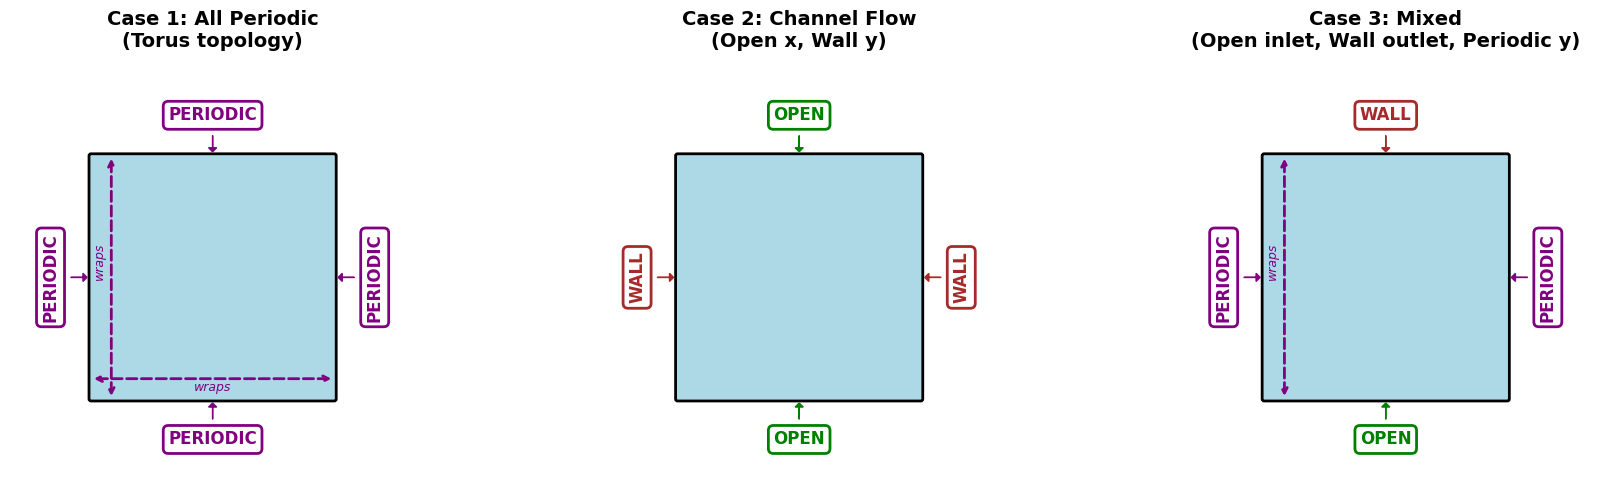


💡 Key Insight:
The boundary condition determines HOW the model pads the spatial domain.
- PERIODIC → circular padding (wraps around)
- OPEN/WALL → zero padding + special BC flag channels


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

def draw_domain_with_bcs(ax, bc_x, bc_y, title):
    """Draw a 2D domain showing boundary conditions."""
    # Domain
    domain = FancyBboxPatch((2, 2), 6, 6, 
                            boxstyle="round,pad=0.05", 
                            edgecolor='black', 
                            facecolor='lightblue', 
                            linewidth=2)
    ax.add_patch(domain)
    
    # BC labels
    bc_names = {0: 'WALL', 1: 'OPEN', 2: 'PERIODIC'}
    bc_colors = {0: 'brown', 1: 'green', 2: 'purple'}
    
    # Bottom BC
    ax.text(5, 1, f'{bc_names[bc_x[0]]}', ha='center', va='center', 
            fontsize=12, fontweight='bold', color=bc_colors[bc_x[0]],
            bbox=dict(boxstyle='round', facecolor='white', edgecolor=bc_colors[bc_x[0]], linewidth=2))
    ax.arrow(5, 1.5, 0, 0.3, head_width=0.2, head_length=0.1, fc=bc_colors[bc_x[0]], ec=bc_colors[bc_x[0]])
    
    # Top BC
    ax.text(5, 9, f'{bc_names[bc_x[1]]}', ha='center', va='center',
            fontsize=12, fontweight='bold', color=bc_colors[bc_x[1]],
            bbox=dict(boxstyle='round', facecolor='white', edgecolor=bc_colors[bc_x[1]], linewidth=2))
    ax.arrow(5, 8.5, 0, -0.3, head_width=0.2, head_length=0.1, fc=bc_colors[bc_x[1]], ec=bc_colors[bc_x[1]])
    
    # Left BC
    ax.text(1, 5, f'{bc_names[bc_y[0]]}', ha='center', va='center',
            fontsize=12, fontweight='bold', color=bc_colors[bc_y[0]], rotation=90,
            bbox=dict(boxstyle='round', facecolor='white', edgecolor=bc_colors[bc_y[0]], linewidth=2))
    ax.arrow(1.5, 5, 0.3, 0, head_width=0.2, head_length=0.1, fc=bc_colors[bc_y[0]], ec=bc_colors[bc_y[0]])
    
    # Right BC
    ax.text(9, 5, f'{bc_names[bc_y[1]]}', ha='center', va='center',
            fontsize=12, fontweight='bold', color=bc_colors[bc_y[1]], rotation=90,
            bbox=dict(boxstyle='round', facecolor='white', edgecolor=bc_colors[bc_y[1]], linewidth=2))
    ax.arrow(8.5, 5, -0.3, 0, head_width=0.2, head_length=0.1, fc=bc_colors[bc_y[1]], ec=bc_colors[bc_y[1]])
    
    # Add periodic indicators (wrapping arrows)
    if bc_x[0] == 2 and bc_x[1] == 2:  # x periodic
        ax.annotate('', xy=(2, 2.5), xytext=(8, 2.5),
                   arrowprops=dict(arrowstyle='<->', color='purple', lw=2, ls='--'))
        ax.text(5, 2.2, 'wraps', ha='center', fontsize=9, style='italic', color='purple')
    
    if bc_y[0] == 2 and bc_y[1] == 2:  # y periodic
        ax.annotate('', xy=(2.5, 2), xytext=(2.5, 8),
                   arrowprops=dict(arrowstyle='<->', color='purple', lw=2, ls='--'))
        ax.text(2.2, 5, 'wraps', ha='center', fontsize=9, style='italic', color='purple', rotation=90)
    
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

# Example 1: All periodic (torus)
draw_domain_with_bcs(axes[0], [2, 2], [2, 2], 'Case 1: All Periodic\n(Torus topology)')

# Example 2: Channel flow
draw_domain_with_bcs(axes[1], [1, 1], [0, 0], 'Case 2: Channel Flow\n(Open x, Wall y)')

# Example 3: Mixed
draw_domain_with_bcs(axes[2], [1, 0], [2, 2], 'Case 3: Mixed\n(Open inlet, Wall outlet, Periodic y)')

plt.tight_layout()
plt.savefig('boundary_conditions_visual.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Key Insight:")
print("The boundary condition determines HOW the model pads the spatial domain.")
print("- PERIODIC → circular padding (wraps around)")
print("- OPEN/WALL → zero padding + special BC flag channels")

## Part 2: Masking (Two Different Types!)

This is where confusion often arises. There are **two completely different types of masking** in Walrus:

1. **Padded Field Mask** - For handling dimensional padding (fake fields)
2. **Object/Obstacle Mask** - For handling invalid spatial regions

Let's understand each one with examples.

### Type 1: Padded Field Mask

#### The Problem:

Walrus is designed to handle problems in 1D, 2D, and 3D. To maintain dimensional consistency, **all data is padded to 3D**.

**Example:** 2D velocity field
- Real data: `v = (v_x, v_y)` - 2 components
- Padded to 3D: `v = (v_x, v_y, v_z=0)` - 3 components
- The z-dimension has size 1 (singleton)
- `v_z` is **fake** - it's just padding!

#### The Solution:

`padded_field_mask` is a boolean tensor that identifies which fields are real vs padding:

```python
# Shape: [C_var] = number of variable fields
padded_field_mask = [True, True, True, True, False]
#                    v_x   v_y   ρ    blob  v_z
#                    ↑     ↑     ↑    ↑     ↑
#                    real  real  real real  PADDING (fake!)
```

#### What happens during loss computation:

```python
# Before computing loss, filter out padded fields:
y_pred_real = y_pred[..., padded_field_mask]  # Only [v_x, v_y, ρ, blob]
y_ref_real = y_ref[..., padded_field_mask]

loss = compute_loss(y_pred_real, y_ref_real)  # Loss ignores v_z
```

#### Why it's critical:

Without this mask, the model would be penalized for getting `v_z` predictions "wrong", even though `v_z` is meaningless! This would:
- Bias the model toward predicting zero for all padded dimensions
- Waste model capacity learning about fake fields
- Give misleading loss values

In [4]:
# Demonstrate padded field mask
print("=" * 60)
print("PADDED FIELD MASK EXAMPLE")
print("=" * 60)

# Simulate predictions for 2D velocity + density + custom field
B, T, H, W, D, C = 1, 10, 64, 64, 1, 5

# Fake predictions and targets (random for demo)
y_pred = torch.randn(B, T, H, W, D, C)
y_ref = torch.randn(B, T, H, W, D, C)

# Padded field mask
padded_mask = torch.tensor([True, True, True, True, False])  # Last is padding
field_names = ['v_x', 'v_y', 'density', 'blubber', 'v_z (padding)']

print("\nField Configuration:")
for i, (name, is_real) in enumerate(zip(field_names, padded_mask)):
    status = "✓ REAL" if is_real else "✗ PADDING"
    print(f"  Channel {i}: {name:20s} → {status}")

# Compute loss WITHOUT masking (WRONG!)
loss_wrong = (y_pred - y_ref).abs().mean()
print(f"\n❌ Loss WITHOUT masking (includes padding): {loss_wrong:.6f}")

# Compute loss WITH masking (CORRECT!)
y_pred_real = y_pred[..., padded_mask]  # Only real fields
y_ref_real = y_ref[..., padded_mask]
loss_correct = (y_pred_real - y_ref_real).abs().mean()
print(f"✓ Loss WITH masking (only real fields):    {loss_correct:.6f}")

print(f"\nShape before masking: {y_pred.shape}")
print(f"Shape after masking:  {y_pred_real.shape}")
print(f"                      └─ Dropped channel 4 (v_z padding)")

print("\n💡 Key Point:")
print("The padded field mask ensures we only evaluate loss on REAL physics fields,")
print("not on fake dimensions added for dimensional consistency.")

PADDED FIELD MASK EXAMPLE

Field Configuration:
  Channel 0: v_x                  → ✓ REAL
  Channel 1: v_y                  → ✓ REAL
  Channel 2: density              → ✓ REAL
  Channel 3: blubber              → ✓ REAL
  Channel 4: v_z (padding)        → ✗ PADDING

❌ Loss WITHOUT masking (includes padding): 1.127880
✓ Loss WITH masking (only real fields):    1.128886

Shape before masking: torch.Size([1, 10, 64, 64, 1, 5])
Shape after masking:  torch.Size([1, 10, 64, 64, 1, 4])
                      └─ Dropped channel 4 (v_z padding)

💡 Key Point:
The padded field mask ensures we only evaluate loss on REAL physics fields,
not on fake dimensions added for dimensional consistency.


### Type 2: Object/Obstacle Mask

#### The Problem:

Some physics simulations have **invalid spatial regions** where the physics doesn't apply:
- Flow around a cylinder → inside the cylinder is solid (no fluid)
- Acoustic scattering → obstacles where sound can't propagate  
- Porous media → solid grains where flow is blocked

The model shouldn't predict physics in these regions!

#### The Solution:

An **object mask** stored as a constant (time-invariant) field:

```python
# Shape: [B, H, W, D, 1] - spatial mask
# Values: True = INVALID (obstacle), False = VALID (physics applies)

mask = torch.zeros(1, 128, 128, 1, 1, dtype=torch.bool)
mask[0, 50:70, 50:70, 0, 0] = True  # Mark 20x20 obstacle region
```

#### What happens during rollout:

```python
# Check if mask exists in constant fields
if "mask" in constant_field_names:
    # Extract mask
    mask = constant_fields[..., mask_index]
    
    # Zero out predictions in masked regions
    y_pred.masked_fill_(mask, 0)
    y_ref.masked_fill_(mask, 0)
    
    # Loss computation: both are zero in masked regions, so no penalty
```

#### Why it's critical:

- The model shouldn't try to predict velocity inside a solid obstacle
- By zeroing both prediction and target in masked regions, the loss ignores these areas
- This prevents the model from wasting capacity on impossible predictions

OBJECT/OBSTACLE MASK EXAMPLE

Domain: 32x32 grid
Obstacle: Circle at center with radius 5
Masked cells: 69 / 1024 total


/var/folders/28/17t2t7cj4x17kf4plwsxyf_00000gr/T/ipykernel_75920/3067096236.py:50: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/28/17t2t7cj4x17kf4plwsxyf_00000gr/T/ipykernel_75920/3067096236.py:51: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('object_mask_visual.png', dpi=150, bbox_inches='tight')
/Users/Vicky/Documents/UKAEA/Code/Foundation_Models/walrus/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


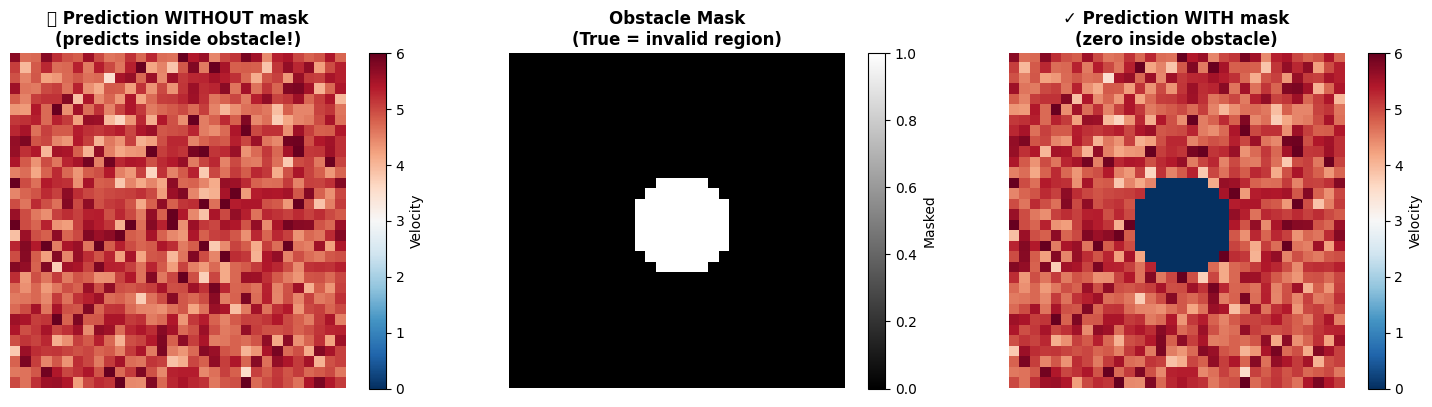


❌ Loss WITHOUT mask: 4.9866
   (penalized for predicting non-zero inside obstacle)

✓ Loss WITH mask:    4.6535
   (obstacle region ignored in loss)

💡 Key Point:
The object mask zeros out predictions in SPATIAL regions where physics doesn't apply,
like inside solid obstacles or boundaries.


In [5]:
# Demonstrate object mask with visualization
print("=" * 60)
print("OBJECT/OBSTACLE MASK EXAMPLE")
print("=" * 60)

# Create a simple 2D domain with an obstacle
H, W = 32, 32
velocity_field = torch.ones(H, W) * 5.0  # Uniform flow

# Add a circular obstacle in the center
y_grid, x_grid = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
center_y, center_x = H // 2, W // 2
radius = 5
distance = torch.sqrt((x_grid - center_x)**2 + (y_grid - center_y)**2)
obstacle_mask = distance < radius  # True inside obstacle

print(f"\nDomain: {H}x{W} grid")
print(f"Obstacle: Circle at center with radius {radius}")
print(f"Masked cells: {obstacle_mask.sum().item()} / {H*W} total")

# Simulate prediction (model might predict non-zero in obstacle)
prediction = velocity_field.clone()
prediction += torch.randn_like(prediction) * 0.5  # Add noise

# Apply mask
prediction_masked = prediction.clone()
prediction_masked[obstacle_mask] = 0  # Zero out obstacle

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original prediction (before masking)
im1 = axes[0].imshow(prediction.numpy(), cmap='RdBu_r', vmin=0, vmax=6)
axes[0].set_title('❌ Prediction WITHOUT mask\n(predicts inside obstacle!)', fontsize=12, fontweight='bold')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], label='Velocity')

# Obstacle mask
im2 = axes[1].imshow(obstacle_mask.numpy(), cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Obstacle Mask\n(True = invalid region)', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], label='Masked')

# Masked prediction (correct)
im3 = axes[2].imshow(prediction_masked.numpy(), cmap='RdBu_r', vmin=0, vmax=6)
axes[2].set_title('✓ Prediction WITH mask\n(zero inside obstacle)', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2], label='Velocity')

plt.tight_layout()
plt.savefig('object_mask_visual.png', dpi=150, bbox_inches='tight')
plt.show()

# Compute losses
target = torch.zeros_like(velocity_field)  # Target is zero everywhere
loss_unmasked = (prediction - target).abs().mean()
loss_masked = (prediction_masked - target).abs().mean()

print(f"\n❌ Loss WITHOUT mask: {loss_unmasked:.4f}")
print(f"   (penalized for predicting non-zero inside obstacle)")
print(f"\n✓ Loss WITH mask:    {loss_masked:.4f}")
print(f"   (obstacle region ignored in loss)")

print("\n💡 Key Point:")
print("The object mask zeros out predictions in SPATIAL regions where physics doesn't apply,")
print("like inside solid obstacles or boundaries.")

## Comparison: Two Types of Masking

Let's put it all together with a clear comparison:

| Aspect | Padded Field Mask | Object Mask |
|--------|-------------------|-------------|
| **What it masks** | Fake fields from dimensional padding | Invalid spatial regions |
| **Shape** | `[C]` - one per field | `[B, H, W, D, 1]` - spatial |
| **Values** | `True`=real, `False`=padding | `True`=invalid, `False`=valid |
| **Purpose** | Don't penalize predictions on non-physical dimensions | Don't predict inside obstacles |
| **Example** | `v_z` in 2D problem | Inside a solid cylinder |
| **When applied** | Before loss computation | During rollout |
| **Always present?** | Yes (always have field mask) | No (optional, dataset-specific) |

### Memory Trick:

- **Field mask**: "Which **CHANNELS** are real?" (masks in channel dimension)
- **Object mask**: "Which **LOCATIONS** are valid?" (masks in spatial dimensions)

In [6]:
# Combined example showing both masks
print("=" * 70)
print("COMBINED EXAMPLE: Both Masks Working Together")
print("=" * 70)

# Setup: 2D flow around cylinder
B, T, H, W, D = 1, 1, 32, 32, 1
C_var = 5  # v_x, v_y, density, blubber, v_z(padding)

# Padded field mask (channel dimension)
padded_field_mask = torch.tensor([True, True, True, True, False])
field_names = ['v_x', 'v_y', 'density', 'blubber', 'v_z(pad)']

# Object mask (spatial dimension) - circular obstacle
y_grid, x_grid = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
distance = torch.sqrt((x_grid - W//2)**2 + (y_grid - H//2)**2)
object_mask = (distance < 5).unsqueeze(0).unsqueeze(0).unsqueeze(-1)  # [B, H, W, D, 1]

# Create fake predictions
y_pred = torch.randn(B, T, H, W, D, C_var)
y_ref = torch.randn(B, T, H, W, D, C_var)

print("\n📊 Data Shape: [B, T, H, W, D, C] =", list(y_pred.shape))
print("\n🔍 Step 1: Apply Object Mask (spatial)")
print(f"   Obstacle mask shape: {object_mask.shape}")
print(f"   Masked locations: {object_mask.sum().item()} cells")

# Expand object mask to match prediction shape
from walrus.trainer.training import expand_mask_to_match
object_mask_expanded = object_mask.expand(B, H, W, D, C_var).unsqueeze(1)  # Add time dim

# Apply object mask
y_pred_obj_masked = y_pred.clone()
y_pred_obj_masked.masked_fill_(object_mask_expanded, 0)
y_ref_obj_masked = y_ref.clone()
y_ref_obj_masked.masked_fill_(object_mask_expanded, 0)

print(f"   → Zeroed out obstacle regions in all {C_var} fields")

print("\n🔍 Step 2: Apply Field Mask (channels)")
print(f"   Padded field mask: {padded_field_mask.tolist()}")
print("   Field configuration:")
for i, (name, is_real) in enumerate(zip(field_names, padded_field_mask)):
    status = "✓ REAL" if is_real else "✗ PADDING"
    print(f"     Channel {i}: {name:15s} → {status}")

# Apply field mask
y_pred_final = y_pred_obj_masked[..., padded_field_mask]
y_ref_final = y_ref_obj_masked[..., padded_field_mask]

print(f"   → Kept only real fields, dropped v_z padding")

print("\n📉 Loss Computation:")
loss_no_masks = (y_pred - y_ref).abs().mean()
loss_obj_only = (y_pred_obj_masked - y_ref_obj_masked).abs().mean()
loss_both = (y_pred_final - y_ref_final).abs().mean()

print(f"   ❌ No masks:              {loss_no_masks:.6f}")
print(f"   🟡 Object mask only:      {loss_obj_only:.6f}")
print(f"   ✓ Both masks (CORRECT):  {loss_both:.6f}")

print("\n🎯 Final shapes:")
print(f"   Before masking: [B={B}, T={T}, H={H}, W={W}, D={D}, C={C_var}]")
print(f"   After masking:  [B={B}, T={T}, H={H}, W={W}, D={D}, C={padded_field_mask.sum().item()}]")
print(f"   → Dropped {(~padded_field_mask).sum().item()} padded field(s)")
print(f"   → Zeroed {object_mask.sum().item()} obstacle location(s)")

print("\n" + "=" * 70)
print("💡 TAKEAWAY")
print("=" * 70)
print("Both masks work together:")
print("  1. Object mask → zeros out SPATIAL regions (obstacle)")
print("  2. Field mask → drops fake CHANNELS (padding)")
print("\nResult: Loss only evaluated on real fields in valid spatial regions!")
print("=" * 70)

COMBINED EXAMPLE: Both Masks Working Together

📊 Data Shape: [B, T, H, W, D, C] = [1, 1, 32, 32, 1, 5]

🔍 Step 1: Apply Object Mask (spatial)
   Obstacle mask shape: torch.Size([1, 1, 32, 32, 1])
   Masked locations: 69 cells


RuntimeError: The expanded size of the tensor (1) must match the existing size (32) at non-singleton dimension 3.  Target sizes: [1, 32, 32, 1, 5].  Tensor sizes: [1, 1, 32, 32, 1]

## Practical Guide: When Do You Need Each?

### Padded Field Mask (Always needed)

**You need this if:**
- You have 2D data (need to pad to 3D)
- You have 1D data (need to pad to 3D)
- You have vector fields with fewer than 3 components
- You have tensor fields in lower dimensions

**Example scenarios:**
```python
# 2D incompressible flow: (v_x, v_y, p)
# Need to add v_z padding
fields = ['v_x', 'v_y', 'pressure', 'v_z']  
padded_mask = [True, True, True, False]  # v_z is padding

# 1D wave equation: (u)
# Need to add y and z padding  
# Scalar is fine, but if you track gradient (∂u/∂x), you need (∂u/∂x, 0, 0)
```

### Object Mask (Optional, dataset-specific)

**You need this if:**
- Your domain has solid obstacles (flow around cylinder)
- You have invalid/boundary regions (scattering problems)
- Some spatial locations should have zero field values (walls in incompressible flow)
- Your geometry has irregular boundaries

**You DON'T need this if:**
- Your domain is empty (no obstacles)
- All spatial locations are valid
- Your boundaries are handled by BCs only

**Example scenarios:**
```python
# Flow around cylinder: need object mask for cylinder interior
# Acoustic scattering: need mask for scattering objects  
# Open channel flow: probably DON'T need object mask
# Periodic turbulence: DON'T need object mask
```

## Summary

### Boundary Conditions
- **Three types**: WALL (0), OPEN (1), PERIODIC (2)
- **Shape**: `[B, 3, 2]` - specify for each dimension's lower/upper bound
- **Spatial padding**: PERIODIC → circular, OPEN/WALL → zero + BC flags
- **Purpose**: Tell model how to treat domain edges during convolution

### Masking Type 1: Padded Field Mask
- **Masks**: Fake fields from dimensional padding (e.g., v_z in 2D)
- **Shape**: `[C]` - boolean per field
- **Applied**: Before loss computation
- **Always needed**: Yes

### Masking Type 2: Object Mask  
- **Masks**: Invalid spatial regions (obstacles, boundaries)
- **Shape**: `[B, H, W, D, 1]` - spatial
- **Applied**: During rollout
- **Optional**: Only if dataset has obstacles

### Key Distinction
- **Field mask**: "Which channels are real?" (eliminates fake fields)
- **Object mask**: "Which locations are valid?" (eliminates obstacles)
- **Both work together**: Object mask zeros spatial regions, field mask drops fake channels

### Common Confusion
The word "padding" appears in multiple contexts:
1. **Spatial padding** for BCs (circular vs zero)
2. **Field padding** for dimensions (adding v_z to 2D velocity)
3. **Masking** to ignore padded regions/fields in loss

These are three separate but related concepts. Understanding each one is crucial for using Walrus correctly!